In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# AutoEncoder Tutorial 

![](https://lilianweng.github.io/posts/2018-08-12-vae/autoencoder-architecture.png)

### Define Transformation

In [2]:
train_transform = transforms.Compose([transforms.RandomResizedCrop(32), transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

test_transform = transforms.Compose([transforms.Resize(32), 
                                     transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

### Load train and test data

In [3]:
train_dataset = datasets.FashionMNIST(root='../data', train=True, download=True, transform=train_transform)

test_dataset = datasets.FashionMNIST(root='../data', train=False, download=True, transform=test_transform)

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, 
                                           shuffle=True, num_workers=4, 
                                           pin_memory=True)



test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True,
                                          num_workers=4, pin_memory=True)

In [5]:
train_batch, _ = next(iter(train_loader))

test_batch, _ = next(iter(test_loader))

In [6]:
train_grid_img = torchvision.utils.make_grid(train_batch, nrow=8)

test_grid_img = torchvision.utils.make_grid(test_batch, nrow=8)

#### Display a batch of training data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


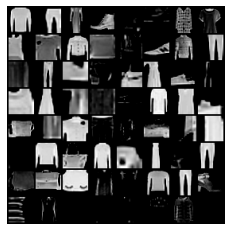

In [7]:
plt.imshow(train_grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

#### Display a batch of test data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


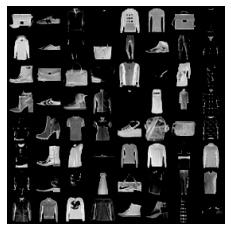

In [8]:
plt.imshow(test_grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [9]:
!python --version

Python 3.7.7


## Define AutoEncoder 

In [10]:
import torch.nn as nn
import torch.nn.init as init

class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)


class AE(nn.Module):
    
    def __init__(self, z_dim=32, nc=1):
        super(AE, self).__init__()
        self.z_dim = z_dim
        self.nc = nc
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, 32, 4, 2, 1, bias=False),              # B,  128, 32, 32
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),             # B,  256, 16, 16
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),             # B,  512,  8,  8
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),            # B, 1024,  4,  4
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            View((-1, 256*2*2)),                                 # B, 1024*2*2
            nn.Linear(256*2*2, z_dim)                            # B, z_dim
        )

        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 256*4*4),                           # B, 1024*4*4
            View((-1, 256, 4, 4)),                               # B, 1024,  4,  4
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),   # B,  512, 8, 8
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),    # B,  256, 16, 16
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),    # B,  128, 32, 32
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, nc, 1),                       # B,   nc, 32, 32
            nn.Tanh()
        )
        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            try:
                for m in self._modules[block]:
                    kaiming_init(m)
            except:
                kaiming_init(block)

    def forward(self, x):
        z = self._encode(x)
        x_recon = self._decode(z)

        return x_recon, z

    def _encode(self, x):
        return self.encoder(x)

    def _decode(self, z):
        return self.decoder(z)
    
def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)

In [11]:
model = AE()
print(model)

data = torch.randn(10, 1, 32, 32)
with torch.no_grad():
    x_recon, z = model(data)
    
print(data.shape)
print(x_recon.shape, z.shape)

AE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): View()
    (13): Linear(in_features=1024, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_feat

### Training

In [12]:
# loss function
criterion = nn.MSELoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
n_epochs = 100

model.train()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model.to(device)

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for i, (images, _) in enumerate(train_loader):
        # _ stands in for labels,
        images = images.to(device)
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        model.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs, _ = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: [{}/{}] \tTraining Loss: {:.6f}'.format(epoch, n_epochs, train_loss))

Epoch: [1/100] 	Training Loss: 3.710335
Epoch: [2/100] 	Training Loss: 1.779062
Epoch: [3/100] 	Training Loss: 1.579386
Epoch: [4/100] 	Training Loss: 1.487399
Epoch: [5/100] 	Training Loss: 1.403304
Epoch: [6/100] 	Training Loss: 1.376721
Epoch: [7/100] 	Training Loss: 1.318728
Epoch: [8/100] 	Training Loss: 1.292424
Epoch: [9/100] 	Training Loss: 1.258502
Epoch: [10/100] 	Training Loss: 1.227497
Epoch: [11/100] 	Training Loss: 1.212916
Epoch: [12/100] 	Training Loss: 1.205564
Epoch: [13/100] 	Training Loss: 1.179365
Epoch: [14/100] 	Training Loss: 1.164213
Epoch: [15/100] 	Training Loss: 1.153320
Epoch: [16/100] 	Training Loss: 1.142224
Epoch: [17/100] 	Training Loss: 1.123951
Epoch: [18/100] 	Training Loss: 1.126444
Epoch: [19/100] 	Training Loss: 1.109834
Epoch: [20/100] 	Training Loss: 1.106233
Epoch: [21/100] 	Training Loss: 1.097184
Epoch: [22/100] 	Training Loss: 1.088209
Epoch: [23/100] 	Training Loss: 1.077739
Epoch: [24/100] 	Training Loss: 1.080564
Epoch: [25/100] 	Training

### Checking the results

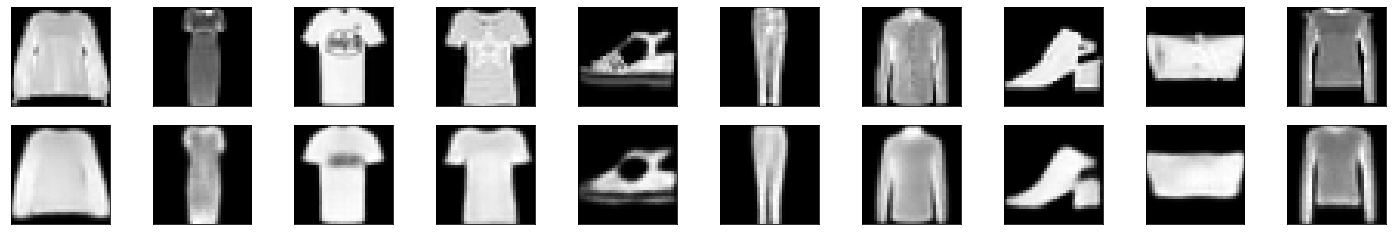

In [14]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)

model.eval()
# get sample outputs
output, _ = model(images)
# prep images for display
images = images.detach().cpu().numpy()


# use detach when it's an output that requires_grad
output = output.detach().cpu().numpy()

images = images[:20]
output = output[:20]

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)